## 7.1 Product affinity

What products are usually bought together? Unfortunately, product names are removed from the Olist dataset due to privacy concerns, but we still have information about the product's categories. Let's get the data necessary to build a graph of the products that appear frequently in the same order. First of all, we'll get a list of products that appear in more than 5 orders:

In [6]:
import sqlite3
import pandas as pd
db_path = '/content/drive/MyDrive/Olist E-Commerce/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [3]:
min_orders = 5

most_ordered_products = f"""
SELECT
    products.product_id,
    product_category_name_english AS category,
    COUNT(order_id) AS orders_count
FROM order_items
    JOIN products USING (product_id)
    JOIN product_category_name_translation AS tr
        ON products.product_category_name = tr.product_category_name
GROUP BY products.product_id
    HAVING COUNT(order_id) > {min_orders}
"""

most_ordered_products_df = pd.read_sql(most_ordered_products, db_connection)
most_ordered_products_df

,product_id,category,orders_count
0,001795ec6f1b187d37335e1c4704762e,consoles_games,9
1,001b72dfd63e9833e8c02742adf472e3,furniture_decor,14
2,00210e41887c2a8ef9f791ebc780cc36,health_beauty,7
3,002159fe700ed3521f46cfcf6e941c76,fashion_shoes,8
4,00250175f79f584c14ab5cecd80553cd,housewares,11
...,...,...,...
3798,ffb97eb64c6fe1baada2410288c04457,perfumery,8
3799,ffc0b406806006602c5853b00ab5f7fd,christmas_supplies,6
3800,ffc9caf33e2d1e9f44e3e06da19085f7,health_beauty,27
3801,ffd4bf4306745865e5692f69bd237893,fashion_bags_accessories,8


We also need to get information about the relationships between products. We can count the number of orders each pair of products appears on using a self-join for combinations of products in the same order and grouping them by product:

In [7]:
most_ordered_product_ids = tuple(most_ordered_products_df['product_id'])

products_often_ordered_together = f"""
SELECT
    oi1.product_id AS product_id1,
    oi2.product_id AS product_id2,
    COUNT(DISTINCT oi1.order_id) AS common_orders_count
FROM order_items AS oi1
    JOIN order_items AS oi2
        ON oi1.order_id = oi2.order_id -- Same order
        AND oi1.product_id < oi2.product_id -- Avoid permutations
WHERE
    oi1.product_id IN {most_ordered_product_ids} AND
    oi2.product_id IN {most_ordered_product_ids}
GROUP BY
    oi1.product_id,
    oi2.product_id
    HAVING COUNT(DISTINCT oi1.order_id) > {min_orders}
"""

products_often_ordered_together_df = pd.read_sql(products_often_ordered_together, db_connection)
products_often_ordered_together_df

,product_id1,product_id2,common_orders_count
0,060cb19345d90064d1015407193c233d,98d61056e0568ba048e5d78038790e77,6
1,0bcc3eeca39e1064258aa1e932269894,422879e10f46682990de24d770e7f83d,6
2,0d85c435fd60b277ffb9e9b0f88f927a,ee57070aa3b24a06fdd0e02efd2d757d,6
3,18486698933fbb64af6c0a255f7dd64c,dbb67791e405873b259e4656bf971246,7
4,35afc973633aaeb6b877ff57b2793310,99a4788cb24856965c36a24e339b6058,29
5,368c6c730842d78016ad823897a372db,53759a2ecddad2bb87a079a1f1519f73,8
6,36f60d45225e60c7da4558b070ce4b60,3f14d740544f37ece8a9e7bc8349797e,12
7,36f60d45225e60c7da4558b070ce4b60,e53e557d5a159f5aa2c5e995dfdf244b,34
8,389d119b48cf3043d311335e499d9c6b,422879e10f46682990de24d770e7f83d,11
9,389d119b48cf3043d311335e499d9c6b,53759a2ecddad2bb87a079a1f1519f73,9


## 7.2 Visualization

With these two sets of data, we can build the graph of products frequently bought together:

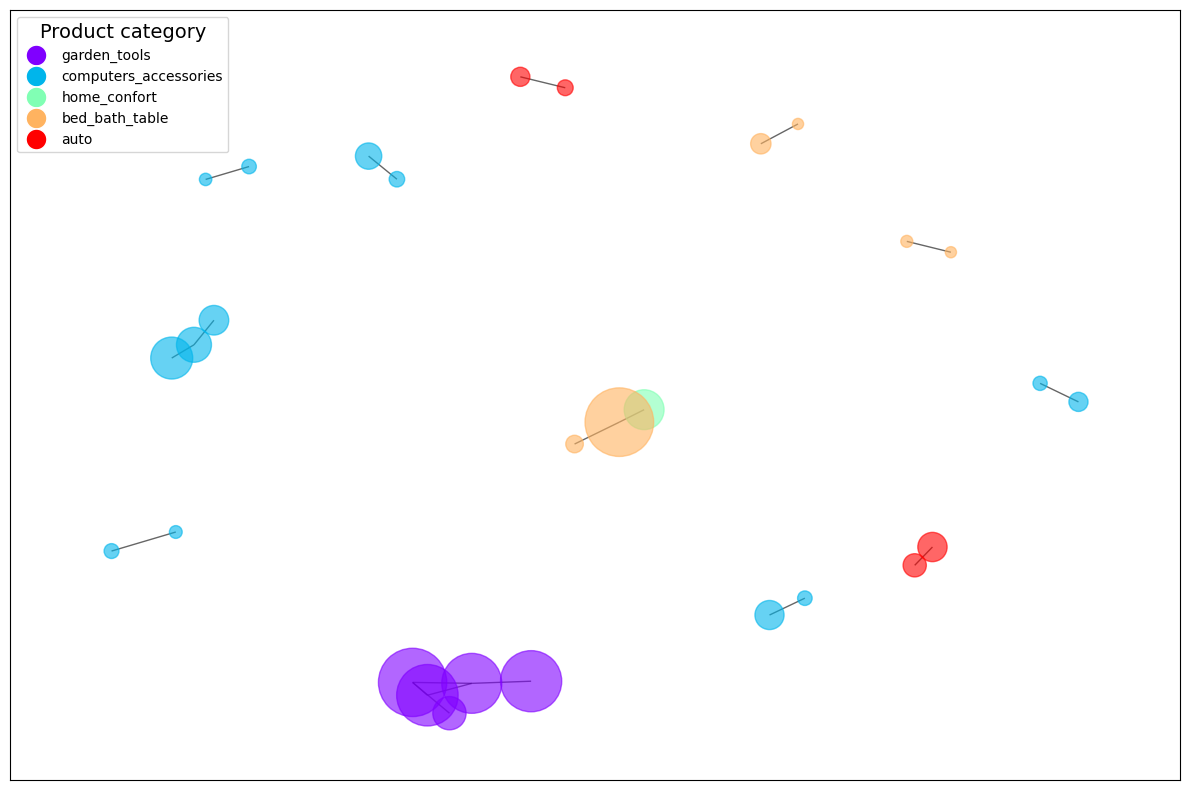

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
G = nx.Graph()
# Add nodes to the graph
for _, product in most_ordered_products_df.iterrows():
    G.add_node(product['product_id'], category=product['category'], orders_count=product['orders_count'])
# Add edges to the graph
for _, pair in products_often_ordered_together_df.iterrows():
    G.add_edge(pair['product_id1'], pair['product_id2'], weight=pair['common_orders_count'])
# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))
# Assign colors to categories
categories = list(set(nx.get_node_attributes(G, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))
# Draw the graph
plt.figure(figsize=(12, 8))
position = nx.spring_layout(G, k=0.5, iterations=50)
node_sizes = [G.nodes[n]['orders_count'] * 5 for n in G.nodes]
node_colors = [category_colors[G.nodes[n]['category']] for n in G.nodes]
nx.draw_networkx(G, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                   for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Product category", loc='upper left', title_fontsize=14)
plt.tight_layout()
plt.show()

In the graph each circle represents a product and its color indicates the product category it belongs to. A line between two products indicates that they are often bought together as part of the same order. The circle's size indicates product importance, how many orders in the whole dataset contain this product.

There are 5 products in the Garden tools category that are often bought together. There's also a product from the Bed, Bath, Table category that is often bought together with another from the Home confort category. We can also observe that some products in the Auto and Computer accessories categories are also often bought with other items of the same category.